In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import mannwhitneyu, wilcoxon, binomtest
from statsmodels.stats.multitest import fdrcorrection
from function import barplot_annotate_brackets
import warnings
from matplotlib.patches import PathPatch
from matplotlib.colors import to_rgb
warnings.simplefilter('ignore')

In [2]:
os.makedirs('../Figure/Figure5', exist_ok=True)

# Load raw_data

In [3]:
family = 'LTR7_HERVH'

Dfam_RM = pd.read_csv('../data/TE/{}.annotation.csv'.format(family))
Dfam_RM.index = Dfam_RM['repeat name']
roadmap = pd.read_table('../data/overlap/LTR7_HERVH_E003_15models.bed', header=None)
roadmap.columns = Dfam_RM.columns.tolist() + ['roadmap chr', 'roadmap start', 'roadmap end', '15 models', 'overlap']

In [4]:
# RNA-seq metadata
GSE99215_metadata = pd.read_csv('../data/RNA-seq/GSE99215_metadata.csv')
display(GSE99215_metadata)

# normalized read count of HERVH
HERVH_GSE99215_nomalized_counts = pd.read_csv('../data/RNA-seq/GSE99215_HERVH_nomalizedcounts.csv', index_col=0)
display(HERVH_GSE99215_nomalized_counts.head())

# TSS metadata
gtf = pd.read_csv('../data/gencode/gencode.v40.annotation_TSS.csv')
display(gtf.head())

# DEG results
GSE99215_nomalized_counts = pd.read_csv('../data/RNA-seq/GSE99215_normalized_counts.csv', index_col=0)
GSE99215_nomalized_counts['gene_name'] = gtf['gene_name'].values
display(GSE99215_nomalized_counts.head())

GSE99215_DEG = pd.read_csv('../data/RNA-seq/TRIM28KO_primed_DEG_analysis.csv', index_col=0)
GSE99215_DEG['gene_name'] = gtf['gene_name'].values
display(GSE99215_DEG.head())

# distance between LTR7_HERVH copy and TSS
Dfam_RM_window = pd.read_csv('../data/overlap/{}.annotation_window_gencode_TSS.bed'.format(family), index_col=0)
Dfam_RM_window

,accession,cell,condition
0,SRR5587546,primed,wild
1,SRR5587547,primed,wild
2,SRR5587548,primed,wild
3,SRR5587549,primed,TRIM28 KO
4,SRR5587550,primed,TRIM28 KO
5,SRR5587551,primed,TRIM28 KO
6,SRR5587552,naive,wild
7,SRR5587553,naive,wild
8,SRR5587554,naive,wild
9,SRR5587555,naive,TRIM28 KO


,SRR5587546,SRR5587547,SRR5587548,SRR5587549,SRR5587550,SRR5587551,SRR5587552,SRR5587553,SRR5587554,SRR5587555,SRR5587556,SRR5587557
Geneid,,,,,,,,,,,,
LTR7up2_HERVH_chr1_dup1,692.623783,728.947315,2484.604032,505.446450,1667.434337,1205.182320,238.551289,286.649726,346.740007,294.012141,285.941180,297.036732
LTR7B3_HERVH_chr1_dup1,43.020111,25.333371,100.839578,28.178199,88.143100,86.213643,60.584454,49.394444,41.220840,45.232637,70.468916,102.477672
LTR7d2_HERVH_chr1_dup1,324.801836,330.151026,2047.979055,317.885311,1504.988790,1038.783961,57.744558,56.682149,75.167414,96.747585,90.796488,103.962856
LTR7d2_HERVH_chr1_dup2,1212.091619,1316.518077,4122.987276,902.582946,4481.457424,3189.904780,71.944040,88.262204,110.326366,95.491123,90.796488,111.388774
LTR7d2_HERVH_chr1_dup3,179.608962,193.677706,788.004124,191.963983,777.261878,556.469876,110.755956,108.505829,136.998674,91.721736,108.413718,114.359142


,chr,start,end,score,strand,frame,source,feature,gene_id,gene_id version,gene_type,gene_name
0,chr1,11869,11870,.,+,.,HAVANA,gene,ENSG00000223972,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1
1,chr1,29570,29571,.,-,.,HAVANA,gene,ENSG00000227232,ENSG00000227232.5,unprocessed_pseudogene,WASH7P
2,chr1,17436,17437,.,-,.,ENSEMBL,gene,ENSG00000278267,ENSG00000278267.1,miRNA,MIR6859-1
3,chr1,29554,29555,.,+,.,HAVANA,gene,ENSG00000243485,ENSG00000243485.5,lncRNA,MIR1302-2HG
4,chr1,30366,30367,.,+,.,ENSEMBL,gene,ENSG00000284332,ENSG00000284332.1,miRNA,MIR1302-2


,SRR5587546,SRR5587547,SRR5587548,SRR5587549,SRR5587550,SRR5587551,SRR5587552,SRR5587553,SRR5587554,SRR5587555,SRR5587556,SRR5587557,gene_name
ENSG00000223972.5,2.151005,3.268822,3.118750,3.522275,0.728455,3.617356,2.839896,4.858470,8.486644,7.538772,2.710343,8.911102,DDX11L1
ENSG00000227232.5,18.283546,14.709699,8.316666,9.686256,6.556098,12.057852,30.292228,33.199544,35.158953,27.642166,17.617228,38.614775,WASH7P
ENSG00000278267.1,2.151005,0.000000,1.039583,0.880569,0.000000,0.000000,1.893264,0.000000,0.000000,0.000000,0.000000,0.000000,MIR6859-1
ENSG00000243485.5,2.151005,0.817206,0.000000,0.880569,0.000000,0.602893,0.946632,0.809745,0.000000,0.000000,0.000000,0.000000,MIR1302-2HG
ENSG00000284332.1,1.075503,0.000000,0.000000,0.880569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MIR1302-2


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
ENSG00000223972.5,3.205495,0.105239,1.122733,0.093735,0.925320,0.999816,DDX11L1
ENSG00000227232.5,13.571198,0.514338,0.620854,0.828436,0.407423,0.999816,WASH7P
ENSG00000278267.1,0.798409,1.983284,2.463168,0.805176,0.420718,NaN,MIR6859-1
ENSG00000243485.5,0.863386,0.984375,2.191674,0.449143,0.653329,NaN,MIR1302-2HG
ENSG00000284332.1,0.381479,0.391259,3.466363,0.112873,0.910131,NaN,MIR1302-2


,repeat chr,repeat start,repeat end,repeat name,repeat adjusted name,repeat score,repeat strand,repeat family name,repeat subfamily name,repeat adjusted subfamily name,...,score,strand,frame,source,feature,gene_id,gene_id version,gene_type,gene_name,distance
0,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,-,.,HAVANA,gene,ENSG00000215374,ENSG00000215374.6,lncRNA,FAM66B,46931
1,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,-,.,HAVANA,gene,ENSG00000215372,ENSG00000215372.6,protein_coding,ZNF705G,16732
2,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,+,.,HAVANA,gene,ENSG00000215371,ENSG00000215371.3,unprocessed_pseudogene,DEFB108C,29176
3,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,-,.,HAVANA,gene,ENSG00000177257,ENSG00000177257.3,protein_coding,DEFB4B,8687
4,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,+,.,HAVANA,gene,ENSG00000255128,ENSG00000255128.1,processed_pseudogene,HSPD1P3,10815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,chrX,153094556,153101476,LTR7C_HERVH_chrX_dup2,LTR7_HERVH_5_dup31,2746/6973/6973/15879/1532/2812,-,LTR7_HERVH,LTR7C_HERVH,LTR7_HERVH_5,...,.,-,.,HAVANA,gene,ENSG00000229979,ENSG00000229979.1,processed_pseudogene,HMGN2P48,42143
909,chrX,153094556,153101476,LTR7C_HERVH_chrX_dup2,LTR7_HERVH_5_dup31,2746/6973/6973/15879/1532/2812,-,LTR7_HERVH,LTR7C_HERVH,LTR7_HERVH_5,...,.,+,.,HAVANA,gene,ENSG00000183837,ENSG00000183837.10,protein_coding,PNMA3,38147
910,chrX,153094556,153101476,LTR7C_HERVH_chrX_dup2,LTR7_HERVH_5_dup31,2746/6973/6973/15879/1532/2812,-,LTR7_HERVH,LTR7C_HERVH,LTR7_HERVH_5,...,.,+,.,HAVANA,gene,ENSG00000235961,ENSG00000235961.6,protein_coding,PNMA6A,22102
911,chrX,153094556,153101476,LTR7C_HERVH_chrX_dup2,LTR7_HERVH_5_dup31,2746/6973/6973/15879/1532/2812,-,LTR7_HERVH,LTR7C_HERVH,LTR7_HERVH_5,...,.,-,.,HAVANA,gene,ENSG00000268883,ENSG00000268883.2,unprocessed_pseudogene,PNMA6B,17588


# Process raw_data

In [5]:
# modify name from systematic name to reodered name
reorder_dict = {'LTR7_HERVH_5': 'LTR7_HERVH_1', 'LTR7_HERVH_4': 'LTR7_HERVH_2', 'LTR7_HERVH_1': 'LTR7_HERVH_3', 'LTR7_HERVH_7': 'LTR7_HERVH_4',
                'LTR7_HERVH_2': 'LTR7_HERVH_5', 'LTR7_HERVH_3': 'LTR7_HERVH_6', 'LTR7_HERVH_6': 'LTR7_HERVH_7', 'LTR7_HERVH_0': 'LTR7_HERVH_8'}

In [6]:
primed_HERVH_wild = HERVH_GSE99215_nomalized_counts[HERVH_GSE99215_nomalized_counts.columns[:3]].mean(axis=1).rename('primed wild')
primed_HERVH_KO = HERVH_GSE99215_nomalized_counts[HERVH_GSE99215_nomalized_counts.columns[3:6]].mean(axis=1).rename('primed KO')

HERVH_GSE99215_nomalized_counts_mean = pd.concat([primed_HERVH_wild, primed_HERVH_KO], axis=1)
HERVH_GSE99215_nomalized_counts_mean['repeat adjusted subfamily name'] = Dfam_RM['repeat adjusted subfamily name']
HERVH_GSE99215_nomalized_counts_mean.head()

,primed wild,primed KO,repeat adjusted subfamily name
Geneid,,,
LTR7up2_HERVH_chr1_dup1,1302.058376,1126.021036,LTR7_HERVH_0
LTR7B3_HERVH_chr1_dup1,56.397686,67.511647,LTR7_HERVH_5
LTR7d2_HERVH_chr1_dup1,900.977306,953.886021,LTR7_HERVH_2
LTR7d2_HERVH_chr1_dup2,2217.198991,2857.981717,LTR7_HERVH_2
LTR7d2_HERVH_chr1_dup3,387.096931,508.565245,LTR7_HERVH_2


# Fig.5A

LTR7_HERVH_1 8.019618690013885e-06 1.3963877237789555
LTR7_HERVH_2 4.528524703603652e-10 2.919195218005895
LTR7_HERVH_3 1.7073194394319448e-07 1.5827278497512958
LTR7_HERVH_4 0.10986328125 1.227907782299109
LTR7_HERVH_5 5.397708492613855e-12 2.0916704397291332
LTR7_HERVH_6 0.2615199089050293 1.622596784036719
LTR7_HERVH_7 0.19368016719818115 0.9105375395359624
LTR7_HERVH_8 1.526934495683354e-09 0.72471973481147


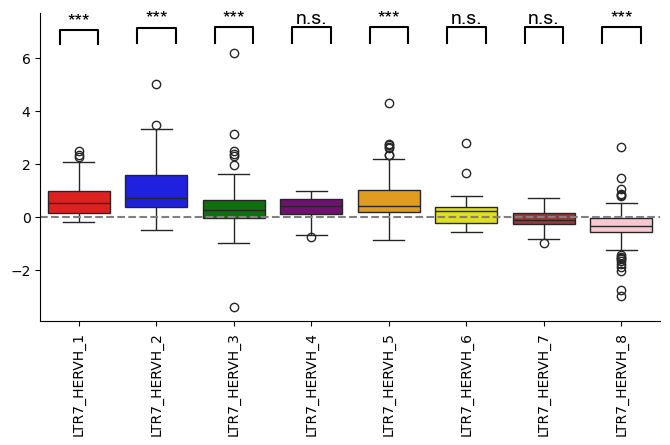

In [7]:
fig = plt.figure(figsize=[8, 4])
ax = plt.subplot()
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14

data = HERVH_GSE99215_nomalized_counts_mean
x = data['repeat adjusted subfamily name']
y =  ((data['primed KO']+1) / (data['primed wild']+1)).apply(np.log2)
order = reorder_dict.keys()
pallete = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink']

sns.boxplot(x=x, y=y, order=order, palette=pallete, ax=ax)

xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], linestyles='dashed', color='grey')

ax.set_xlim(xlim[0], xlim[1])
#ax.set_ylim(ax.get_ylim()[0], 4.2)
#ax.set_xlabel('repeat subfamily name')
#ax.set_ylabel('log2 Fold change')
ax.set_xlabel('')
ax.set_ylabel('')

[ax.spines[loc].set_visible(False) for loc in ['top','right']]
a = ax.set_xticklabels(['LTR7_HERVH_{}'.format(i) for i in range(1, 9)], rotation=90)

# Statistical test
for i,subfamily in enumerate(reorder_dict.keys()):

    data = HERVH_GSE99215_nomalized_counts_mean[HERVH_GSE99215_nomalized_counts_mean['repeat adjusted subfamily name']==subfamily].dropna()
    x = data['primed wild']
    y = data['primed KO']
    diff = y.mean() / x.mean()
    ratio = ((data['primed KO']+1) / (data['primed wild']+1)).apply(np.log2)
    ratio_max = ratio.quantile(q=0.75) + ((ratio.quantile(q=0.75) - ratio.quantile(q=0.25)) * 1.5)

    p = wilcoxon(x, y)

    barplot_annotate_brackets(0, 1, p[1], [i-0.25, i+0.25], [6, 6], maxasterix=3)

    print(reorder_dict[subfamily], p[1], diff)

fig.savefig('../Figure/Figure5/Figure5A.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure5/Figure5A.pdf', bbox_inches='tight', transparent=True, dpi=300)

# Fig.5B

In [9]:
# summarize roadmap data
roadmap_crosstab = pd.crosstab(roadmap['repeat name'], roadmap['15 models']) >=1
roadmap_crosstab = pd.concat([Dfam_RM, roadmap_crosstab], axis=1)

In [10]:
# relationship with 9_Het
state = 9
data = pd.concat([roadmap_crosstab, HERVH_GSE99215_nomalized_counts_mean], axis=1)
data['log2 FC'] = ((data['primed KO']+1) / (data['primed wild']+1)).apply(np.log2)
x = data['repeat adjusted subfamily name'].values[:, 0]
y = data['log2 FC']
hue = data[state]
p_list = list()
for subfamily in reorder_dict.keys():

    d = data[data['repeat adjusted subfamily name'].values[:, 0]==subfamily]
    F = d[d[state]==False]['log2 FC']
    T = d[d[state]==True]['log2 FC']

    try:
        p = mannwhitneyu(F, T)[1]
        print(reorder_dict[subfamily], len(d), len(F), len(T), p)
        p_list.append(p)
    
    except:
        pass

print(fdrcorrection(p_list))

LTR7_HERVH_1 31 24 7 0.03327077569569227
LTR7_HERVH_2 59 44 15 0.015909915623432313
LTR7_HERVH_3 126 92 34 0.0019910660479157648
LTR7_HERVH_4 13 11 2 1.0
LTR7_HERVH_5 85 65 20 0.002615497015277246
LTR7_HERVH_6 22 18 4 0.22693096377306904
LTR7_HERVH_7 27 22 5 0.07469342251950947
LTR7_HERVH_8 116 101 15 0.0063012747238477855
(array([False,  True,  True, False,  True, False, False,  True]), array([0.05323324, 0.03181983, 0.01046199, 1.        , 0.01046199,
       0.25934967, 0.09959123, 0.0168034 ]))


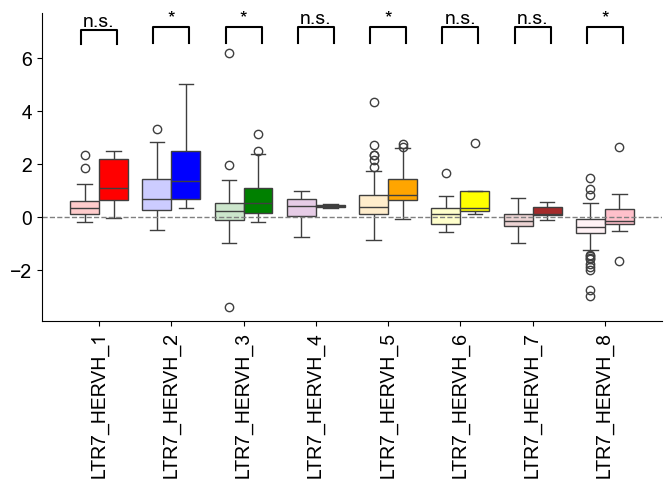

In [11]:
# relationship with 9_Het
np.random.seed(20230215)
hue_order = ['A', 'B']


fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14

state = 9
data = pd.concat([roadmap_crosstab, HERVH_GSE99215_nomalized_counts_mean[['primed wild', 'primed KO']]], axis=1)
data['log2 FC'] = ((data['primed KO']+1) / (data['primed wild']+1)).apply(np.log2)
x = data['repeat adjusted subfamily name']
y = data['log2 FC']
hue = data[state]
order = reorder_dict.keys()
hue_order = [False, True]
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink']

sns.boxplot(x=x, y=y, hue=hue,
            order=order, hue_order=hue_order, ax=ax)

box_colors = [f + (1 - f) * np.array(to_rgb(c))  
              for c in colors for f in reversed(np.linspace(0, 0.8, len(hue_order)))]
              
box_patches = [p for p in ax.patches if isinstance(p, PathPatch)]

for i in range(8):

    box_patches[i].set_facecolor(box_colors[i*2])
    box_patches[i+8].set_facecolor(box_colors[i*2+1])


ax.axhline(y=0, linestyle='--', color='grey', linewidth=1)

#ax.set_ylim(ax.get_ylim()[0], 6.5)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(reorder_dict.values())
plt.legend().remove()
plt.xticks(rotation=90)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]


# 有意差
for i, p in enumerate(fdrcorrection(p_list)[1]):

    if p < 0.05:
        
        barplot_annotate_brackets(0, 1, p, [i-0.25, i+0.25], [6, 6], maxasterix=3)

    else:
        
        barplot_annotate_brackets(0, 1, p, [i-0.25, i+0.25], [6, 6], maxasterix=3)

fig.savefig('../Figure/Figure5/Figure5B.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure5/Figure5B.pdf', bbox_inches='tight', transparent=True, dpi=300)

# Fig.5C

In [12]:

DEG_list = list()
for FC, padj in GSE99215_DEG[['log2FoldChange', 'padj']].values:

    if padj < 0.05 and FC > 0:

        D = 'wild'

    elif padj < 0.05 and FC < 0:

        D = 'TRIM28'
    
    else:

        D = 'non-DEG'

    DEG_list.append(D)
  
GSE99215_DEG['DEG'] = DEG_list
GSE99215_DEG_fil = GSE99215_DEG[GSE99215_DEG['padj'].isna()==False]
GSE99215_DEG_dict = GSE99215_DEG.to_dict()


# add DEG results
Dfam_RM_window['padj'] = Dfam_RM_window['gene_id version'].apply(lambda x:GSE99215_DEG_dict['padj'][x])
Dfam_RM_window['DEG'] = Dfam_RM_window['gene_id version'].apply(lambda x:GSE99215_DEG_dict['DEG'][x])
Dfam_RM_window_fil = Dfam_RM_window[Dfam_RM_window['padj'].isna()==False]
Dfam_RM_window_fil

,repeat chr,repeat start,repeat end,repeat name,repeat adjusted name,repeat score,repeat strand,repeat family name,repeat subfamily name,repeat adjusted subfamily name,...,frame,source,feature,gene_id,gene_id version,gene_type,gene_name,distance,padj,DEG
0,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,HAVANA,gene,ENSG00000215374,ENSG00000215374.6,lncRNA,FAM66B,46931,0.999816,non-DEG
1,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,HAVANA,gene,ENSG00000215372,ENSG00000215372.6,protein_coding,ZNF705G,16732,0.339565,non-DEG
4,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,HAVANA,gene,ENSG00000255128,ENSG00000255128.1,processed_pseudogene,HSPD1P3,10815,0.999816,non-DEG
6,chr6,131323296,131329139,LTR7up1_HERVH_chr6_dup8,LTR7_HERVH_0_dup85,3663/5541/16900/993/3462/4922/1495/2367/3694,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,HAVANA,gene,ENSG00000289262,ENSG00000289262.1,lncRNA,ENSG00000289262,28879,0.999816,non-DEG
7,chr12,79539848,79545627,LTR7up1_HERVH_chr12_dup4,LTR7_HERVH_0_dup23,3962/23172/1036/3873/5257/1510/2591/4064,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,.,HAVANA,gene,ENSG00000257894,ENSG00000257894.2,lncRNA,ENSG00000257894,36452,0.402668,non-DEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,chr7,99723170,99729932,LTR7C_HERVH_chr7_dup1,LTR7_HERVH_5_dup23,2533/2057/4348/6875/2528,+,LTR7_HERVH,LTR7C_HERVH,LTR7_HERVH_5,...,.,HAVANA,gene,ENSG00000160870,ENSG00000160870.15,protein_coding,CYP3A7,5264,0.999816,non-DEG
904,chr2,215089939,215096031,LTR7BC_HERVH_chr2_dup6,LTR7_HERVH_5_dup17,2632/2238/20639/2616/3764/2532,+,LTR7_HERVH,LTR7BC_HERVH,LTR7_HERVH_5,...,.,HAVANA,gene,ENSG00000144452,ENSG00000144452.15,protein_coding,ABCA12,42595,0.999816,non-DEG
906,chr17,55467773,55476510,LTR7u2_HERVH_chr17_dup2,LTR7_HERVH_5_dup13,2264/1858/6255/11790/1103/4028/3012/4286/2674,+,LTR7_HERVH,LTR7u2_HERVH,LTR7_HERVH_5,...,.,HAVANA,gene,ENSG00000108960,ENSG00000108960.9,protein_coding,MMD,45849,0.999816,non-DEG
909,chrX,153094556,153101476,LTR7C_HERVH_chrX_dup2,LTR7_HERVH_5_dup31,2746/6973/6973/15879/1532/2812,-,LTR7_HERVH,LTR7C_HERVH,LTR7_HERVH_5,...,.,HAVANA,gene,ENSG00000183837,ENSG00000183837.10,protein_coding,PNMA3,38147,0.148421,non-DEG


In [14]:
# calcurate proportion

gene_type_list = ['protein_coding', 'lncRNA', 'miRNA']
Dfam_RM_window_position_gene = Dfam_RM_window_fil[Dfam_RM_window_fil['gene_type'].isin(gene_type_list)]

# count
crosstab = pd.crosstab(Dfam_RM_window_position_gene['repeat adjusted subfamily name'], Dfam_RM_window_position_gene['DEG'])
crosstab = crosstab.loc[reorder_dict.keys()]

# proportion
crosstab_norm = pd.crosstab(Dfam_RM_window_position_gene['repeat adjusted subfamily name'], Dfam_RM_window_position_gene['DEG'], normalize='index')
crosstab_norm = crosstab_norm.loc[reorder_dict.keys()]
crosstab_norm = pd.concat([crosstab_norm.T, GSE99215_DEG_fil['DEG'].value_counts(normalize=True).rename('All gene')], axis=1).T

# modify　name
crosstab = pd.concat([crosstab.T, GSE99215_DEG_fil['DEG'].value_counts().rename('All gene')], axis=1).T
crosstab_norm.index = [reorder_dict[subfamily] for subfamily in crosstab.index[:-1]] + ['All gene']
crosstab_norm


DEG,TRIM28,non-DEG,wild
LTR7_HERVH_1,0.016949,0.983051,0.000000
LTR7_HERVH_2,0.176471,0.803922,0.019608
LTR7_HERVH_3,0.091954,0.850575,0.057471
LTR7_HERVH_4,0.125000,0.875000,0.000000
LTR7_HERVH_5,0.135593,0.796610,0.067797
LTR7_HERVH_6,0.000000,0.950000,0.050000
LTR7_HERVH_7,0.000000,1.000000,0.000000
LTR7_HERVH_8,0.125000,0.787500,0.087500
All gene,0.017564,0.968469,0.013967


In [15]:
# statictical test
FDR_list = list()

for D in ['TRIM28', 'wild']:

    pvalue_list = list()
    exp = crosstab_norm[D]['All gene']

    for subfamily in crosstab.index[:8]:

        k = crosstab[D][subfamily]
        N = crosstab.loc[subfamily].sum()

        p = binomtest(k=k, n=N, p=exp).pvalue
        print(D, subfamily, k, N, p)
        pvalue_list.append(p)

    FDR_list.append(fdrcorrection(pvalue_list)[1])


TRIM28 LTR7_HERVH_5 1 59 1.0
TRIM28 LTR7_HERVH_4 9 51 2.48366817694055e-07
TRIM28 LTR7_HERVH_1 8 87 0.00015423945169868624
TRIM28 LTR7_HERVH_7 1 8 0.13216802736406222
TRIM28 LTR7_HERVH_2 8 59 9.037676078642184e-06
TRIM28 LTR7_HERVH_3 0 20 1.0
TRIM28 LTR7_HERVH_6 0 16 1.0
TRIM28 LTR7_HERVH_0 10 80 1.4989678730342735e-06
wild LTR7_HERVH_5 0 59 1.0
wild LTR7_HERVH_4 1 51 0.5119599430125319
wild LTR7_HERVH_1 5 87 0.007626667281740028
wild LTR7_HERVH_7 0 8 1.0
wild LTR7_HERVH_2 4 59 0.00941383391715674
wild LTR7_HERVH_3 1 20 0.2452108055545737
wild LTR7_HERVH_6 0 16 1.0
wild LTR7_HERVH_0 7 80 0.00013516058357219784


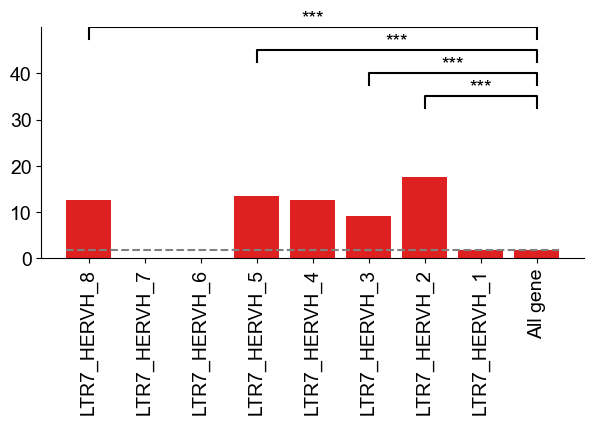

In [17]:
# Visualization
fig = plt.figure(figsize=[7, 3])

ax = plt.subplot()
x = crosstab_norm.index
y = crosstab_norm['TRIM28'] * 100
order = ['All gene'] + list(reorder_dict.values())
order.reverse()

# barplot
sns.barplot(x=x, y=y, order=order, color='red', orient='v', ax=ax)

# all gene
x = crosstab_norm['TRIM28'].loc['All gene']
ax.hlines(x*100, -0.4, 8.4, color='grey', linestyles='dashed')

ax.set_ylim(0, 50)
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_xlabel('')
ax.set_ylabel('')
order = ['All gene'] + list(reorder_dict.values())
order.reverse()
ax.set_xticklabels(order, rotation=90)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]


# significance
count = 0
for i in range(8):

    p = FDR_list[0][i]

    if p < 0.05:
        
        barplot_annotate_brackets(0, 1, p, [7-i, 8], [30+count, 30+count], maxasterix=3)
        count += 5

fig.savefig('../Figure/Figure5/Figure5C_upregulation.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure5/Figure5C_upregulation.pdf', bbox_inches='tight', transparent=True, dpi=300)

1.0
0.819135908820051
0.025103557112417973
1.0
0.025103557112417973
0.4904216111091474
1.0
0.0010812846685775827


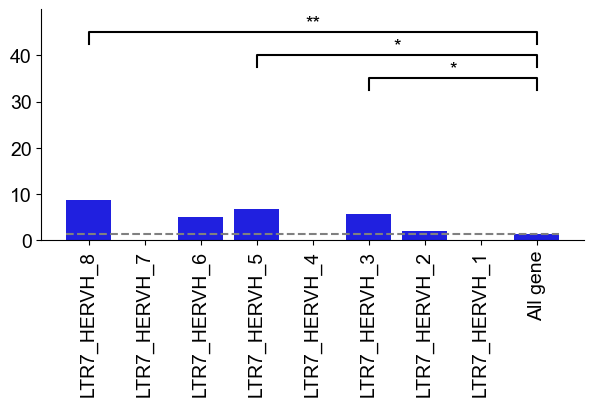

In [18]:
fig = plt.figure(figsize=[7, 3])

ax = plt.subplot()
x = crosstab_norm.index
y = crosstab_norm['wild'] * 100
order = ['All gene'] + list(reorder_dict.values())
order.reverse()

# barplot
sns.barplot(x=x, y=y, order=order, color='blue', orient='v', ax=ax)

# all gene
x = crosstab_norm['wild'].loc['All gene']
ax.hlines(x*100, -0.4, 8.4, color='grey', linestyles='dashed')

ax.set_ylim(0, 50)
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_xlabel('')
ax.set_ylabel('')
order = ['All gene'] + list(reorder_dict.values())
order.reverse()
ax.set_xticklabels(order, rotation=90)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]


# significance
count = 0
for i in range(8):

    p = FDR_list[1][i]
    print(p)

    if p < 0.05:
        
        barplot_annotate_brackets(0, 1, p, [7-i, 8], [30+count, 30+count], maxasterix=3)
        count += 5

plt.rcParams["font.family"] = "Arial"
fig.savefig('../Figure/Figure5/Figure5C_downregulation.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure5/Figure5C_downregulation.pdf', bbox_inches='tight', transparent=True, dpi=300)